In [1]:
from data_preparation import DataPreparator
from apply_clustering import ClusteringApplier

In [2]:
import os.path
from itertools import chain, combinations
from typing import Dict, List, Tuple, Iterable, Any

import numpy as np
import pandas as pd
from gapstatistics.gapstatistics import GapStatistics
from clustering import AgglomerativeClusteringWrapper as AgglomerativeClustering
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform
from scipy.spatial.distance import jensenshannon, correlation, euclidean
from tqdm.contrib.concurrent import thread_map
import seaborn as sns

import config

In [3]:
import torch
from torch.distributions import kl_divergence
from torch.distributions.beta import Beta
from torch.distributions.dirichlet import Dirichlet
from ParameterizedModel.parameterized_model import Paremeterized_Model
from ParameterizedModel.utils.distribution_helpers import mean_std_to_beta_params

from ParameterizedModel.training import Trainer

In [4]:
from gradient_solver import construct_distance_matrix

In [5]:
import timeit

In [6]:
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset

In [7]:
from scipy.spatial.distance import correlation

In [8]:
from gradient_solver import *

In [9]:
'''df_explainable: pd.DataFrame = ClusteringApplier.read_explaining_features()
df_observable_distances: pd.DataFrame = pd.read_excel(
    f"{config.OUTPUT_FOLDER_BASE}observables/{config.DATASET_NAME}-distance-normalized-matrix-{config.DISTANCE_MEASURE_FINGERPRINT}-{config.NUMBER_OBSERVABLE_PATTERNS}.xlsx",
    index_col=0
)
features: List[str] = list(config.EXPLAINING_FEATURE_NAMES.keys())

# Ensure that both datasets contain the same indices
valid_indices = np.intersect1d(df_explainable.index, df_observable_distances.index)
df_explainable = df_explainable.loc[valid_indices]
df_observable_distances = df_observable_distances.loc[valid_indices]'''

'df_explainable: pd.DataFrame = ClusteringApplier.read_explaining_features()\ndf_observable_distances: pd.DataFrame = pd.read_excel(\n    f"{config.OUTPUT_FOLDER_BASE}observables/{config.DATASET_NAME}-distance-normalized-matrix-{config.DISTANCE_MEASURE_FINGERPRINT}-{config.NUMBER_OBSERVABLE_PATTERNS}.xlsx",\n    index_col=0\n)\nfeatures: List[str] = list(config.EXPLAINING_FEATURE_NAMES.keys())\n\n# Ensure that both datasets contain the same indices\nvalid_indices = np.intersect1d(df_explainable.index, df_observable_distances.index)\ndf_explainable = df_explainable.loc[valid_indices]\ndf_observable_distances = df_observable_distances.loc[valid_indices]'

In [10]:
##################
# Synthetic Data #
##################
individuals = 100
base_size = 10000

#observation_data = np.random.normal(loc=0, scale=1, size=(base_size, 6))
'''explanation_data = np.random.uniform(0,1, size=(individuals, 11))
df_explainable = pd.DataFrame(explanation_data)
df_explainable.loc[:, 'Individual'] = [f'Individual_{i}' for i in df_explainable.index]
df_explainable.set_index('Individual', inplace=True)'''

df_explainable = pd.DataFrame({
    'Age': np.random.choice([0., 0.5, 1.], individuals),
    'Weight': np.random.uniform(0,1, size=individuals),
    'Is_a_Zebra': np.random.choice([0., 1.], individuals),
    'Loves_to_sleep': np.random.uniform(0,1, size=individuals),
    'Noise_1': np.random.uniform(0,1, size=individuals),
    'Noise_2': np.random.uniform(0,1, size=individuals),
    'Noise_3': np.random.uniform(0,1, size=individuals),
    'Noise_4': np.random.uniform(0,1, size=individuals),
    'Noise_5': np.random.uniform(0,1, size=individuals),
    'Individual': [f'Individual_{n}' for n in range(individuals)]
})
df_explainable.set_index('Individual', inplace=True)

explaining_features = np.array(list(df_explainable.columns))
individual_array = np.random.choice(df_explainable.index.unique(), size=base_size)

df_observable = pd.DataFrame({
    'Individual': individual_array,
})
df_observable.loc[:, 'unexplainable_1'] = np.random.uniform(0,1, size=base_size)
df_observable.loc[:, 'unexplainable_2'] = np.random.uniform(0,1, size=base_size)
df_observable.loc[:, 'unexplainable_3'] = np.random.uniform(0,1, size=base_size)
df_observable.loc[:, 'unexplainable_4'] = np.random.normal(0,1, size=base_size)

df_observable.loc[:, 'if_zebra_then_age'] = (df_explainable.loc[individual_array, 'Is_a_Zebra'].values > 0.5) * df_explainable.loc[individual_array, 'Age'].values + (df_explainable.loc[individual_array, 'Is_a_Zebra'].values <= 0.5) * np.random.uniform(0,1, size=base_size)
df_observable.loc[:, 'explained_by_loves_to_sleep'] = df_explainable.loc[individual_array, 'Loves_to_sleep'].values #df_explainable.loc[individual_array, [1,2,3]].mean(axis=1).values #req_1 * df_explainable.loc[individual_array, 2].values + (1-req_1) * df_explainable.loc[individual_array, 3].values
df_observable.loc[:, 'Age_plus_Weight'] = df_explainable.loc[individual_array, 'Age'].values + df_explainable.loc[individual_array, 'Weight'].values

df_observable.set_index('Individual', inplace=True)
observed_features = list(df_observable.columns)

df_observable = df_observable.apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=0)
df_explainable = df_explainable.apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=0)

In [11]:
df_explainable

,Age,Weight,Is_a_Zebra,Loves_to_sleep,Noise_1,Noise_2,Noise_3,Noise_4,Noise_5
Individual,,,,,,,,,
Individual_0,0.5,0.951325,0.0,0.250671,0.310481,0.252313,0.799248,0.779194,0.000000
Individual_1,0.0,0.246078,1.0,0.745883,0.763598,0.318206,0.821881,0.458736,0.546275
Individual_2,1.0,0.924722,1.0,0.327230,0.192617,0.725265,0.113948,0.326210,0.667865
Individual_3,1.0,0.200656,0.0,0.499613,0.457526,0.040080,0.559932,0.276426,0.909728
Individual_4,0.5,0.587173,1.0,0.927766,0.010981,0.515719,0.039620,0.245983,0.471347
...,...,...,...,...,...,...,...,...,...
Individual_95,0.0,0.000000,0.0,0.683806,0.531086,0.918360,0.552334,0.993882,0.197058
Individual_96,0.5,0.301165,0.0,0.077817,1.000000,0.087846,0.298220,0.109588,0.207614
Individual_97,0.5,0.591721,0.0,0.411683,0.344778,0.496258,0.965176,0.090230,0.444156


In [12]:
df_observable

,unexplainable_1,unexplainable_2,unexplainable_3,unexplainable_4,if_zebra_then_age,explained_by_loves_to_sleep,Age_plus_Weight
Individual,,,,,,,
Individual_61,0.918024,0.353647,0.398812,0.406362,0.106877,0.487220,0.747860
Individual_48,0.422734,0.647883,0.618953,0.580077,0.297607,0.257392,0.552575
Individual_46,0.246461,0.610178,0.608729,0.254077,0.677801,0.457852,0.818470
Individual_6,0.784919,0.823910,0.487563,0.557078,0.500000,0.735242,0.718951
Individual_5,0.178015,0.386647,0.143816,0.506299,0.734538,0.225195,0.499021
...,...,...,...,...,...,...,...
Individual_71,0.308855,0.092796,0.698702,0.509018,0.914254,0.204047,0.053943
Individual_81,0.013906,0.022566,0.674781,0.499951,0.345552,0.005977,0.273183
Individual_65,0.052819,0.745841,0.670999,0.179428,0.309162,0.934265,0.470486


In [13]:
df_observable.loc['Individual_9']

,unexplainable_1,unexplainable_2,unexplainable_3,unexplainable_4,if_zebra_then_age,explained_by_loves_to_sleep,Age_plus_Weight
Individual,,,,,,,
Individual_9,0.648777,0.025639,0.581436,0.574393,1.0,0.801653,0.616616
Individual_9,0.381813,0.181016,0.988856,0.668911,1.0,0.801653,0.616616
Individual_9,0.474038,0.408185,0.062203,0.556374,1.0,0.801653,0.616616
Individual_9,0.085661,0.726502,0.917030,0.551992,1.0,0.801653,0.616616
Individual_9,0.013588,0.627950,0.579517,0.409397,1.0,0.801653,0.616616
...,...,...,...,...,...,...,...
Individual_9,0.363745,0.148682,0.365065,0.347813,1.0,0.801653,0.616616
Individual_9,0.441037,0.436404,0.171856,0.503465,1.0,0.801653,0.616616
Individual_9,0.915458,0.441345,0.150154,0.547600,1.0,0.801653,0.616616


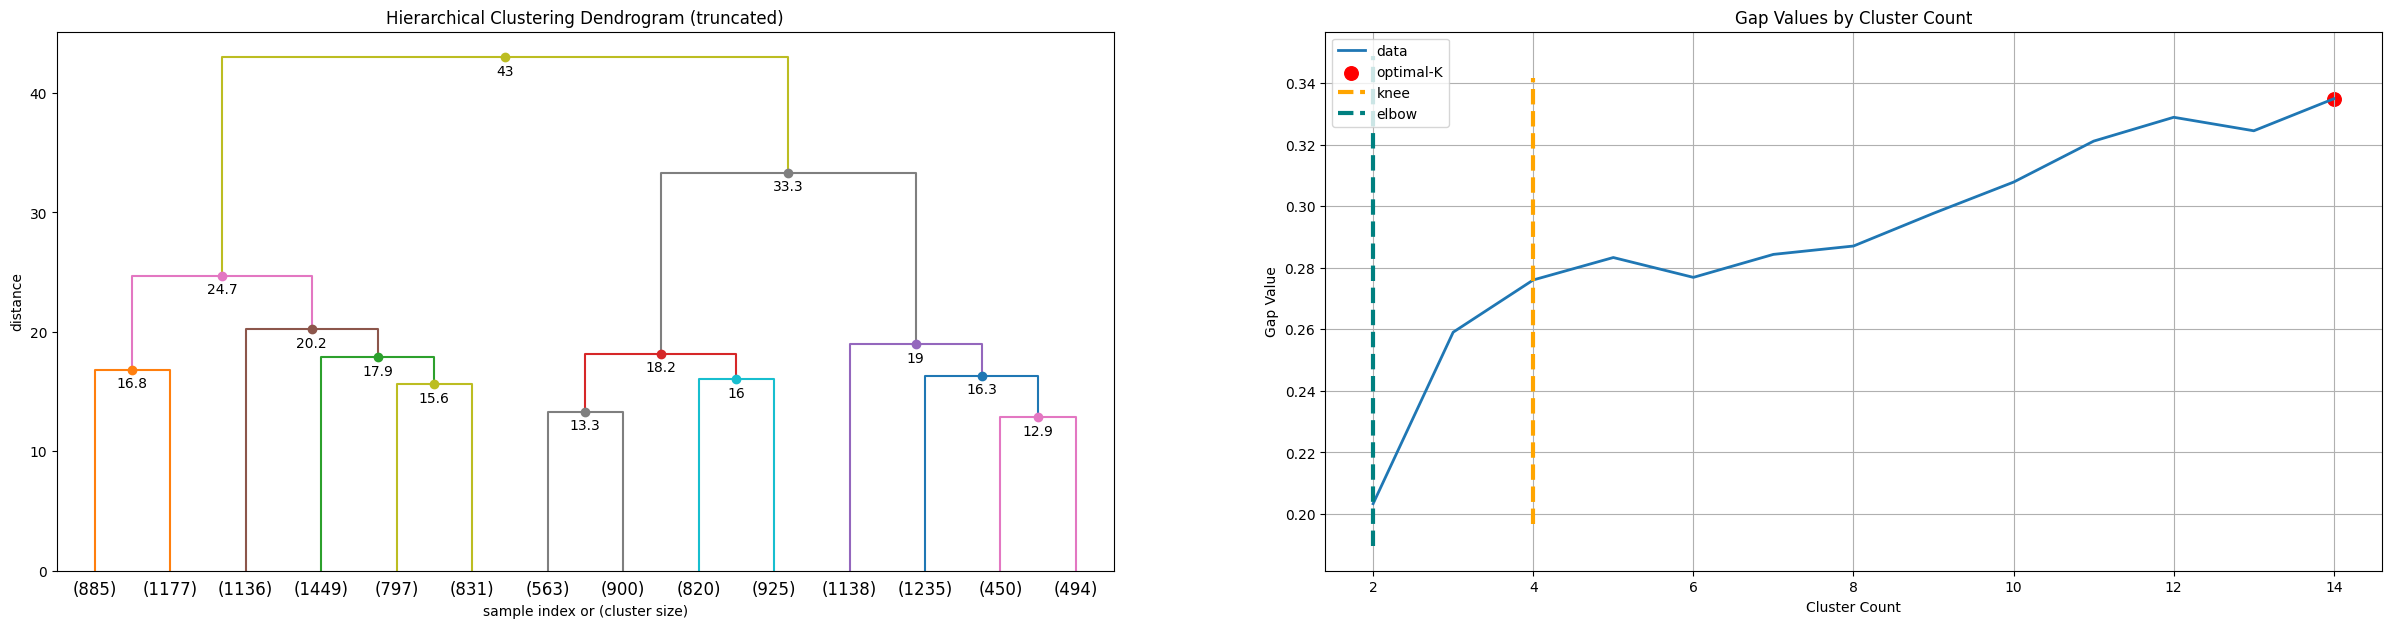

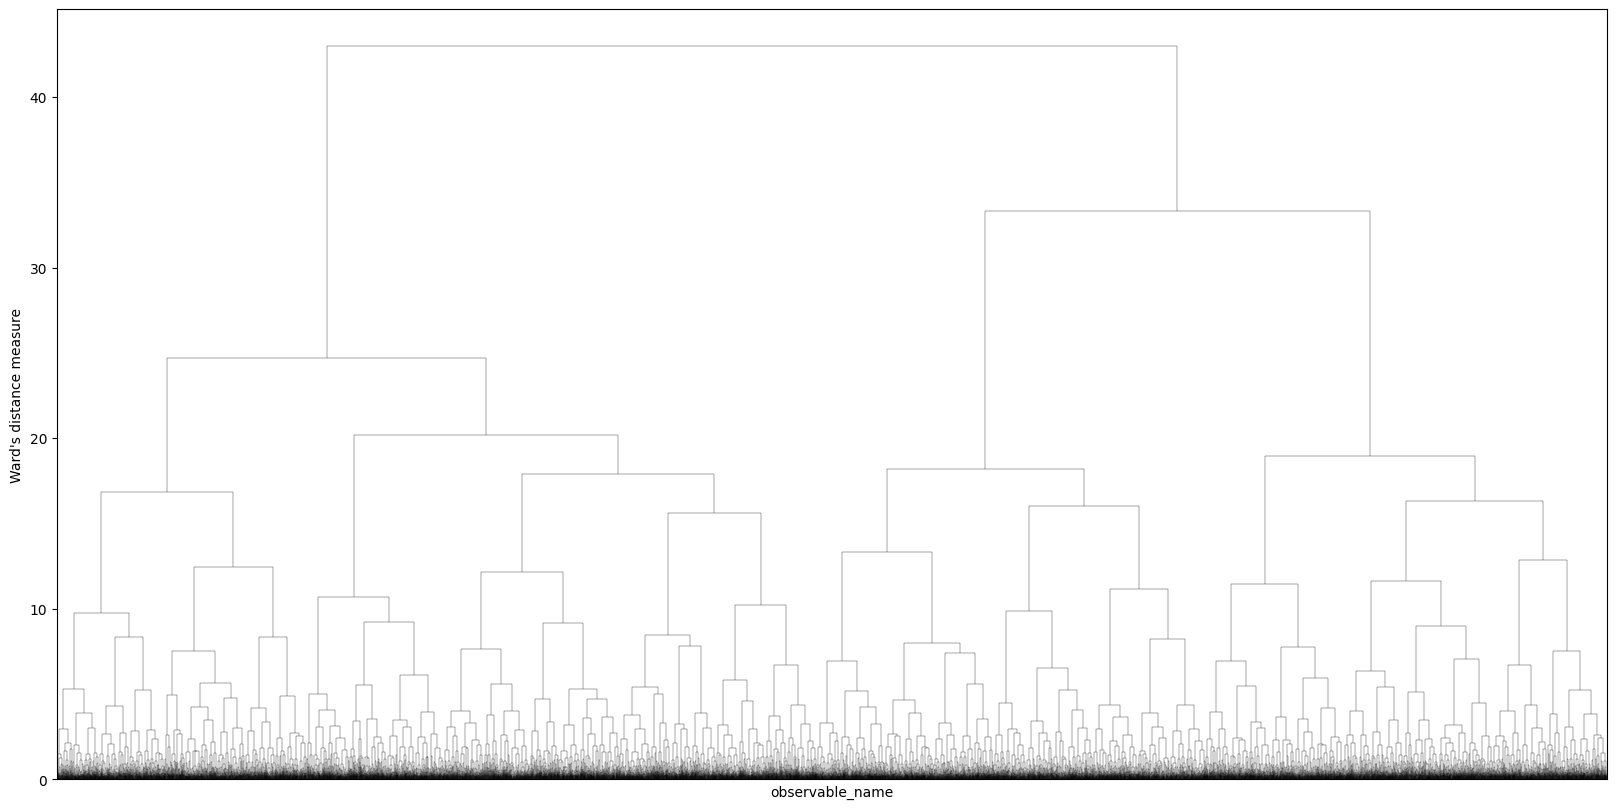

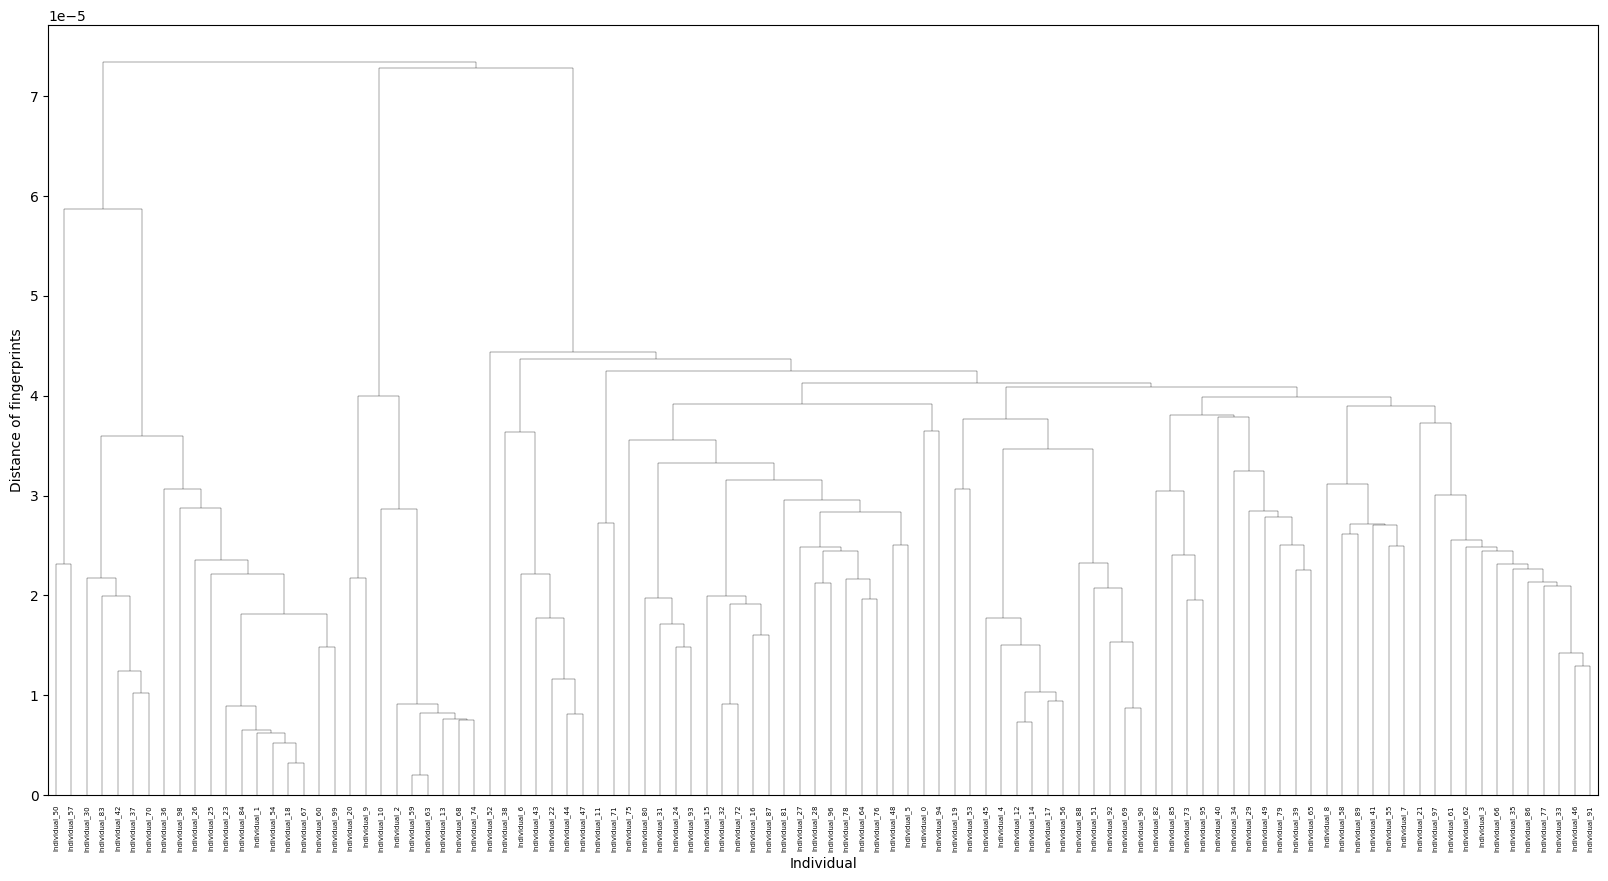

In [14]:
index_name = 'Individual'
my_linkage = 'ward' #'single'

from data_preparation import DataPreparator
from apply_clustering import ClusteringApplier

preparation_result = DataPreparator.prepare_data(
    use_config=False,
    df_observable=df_observable.reset_index(),
    df_explainable=df_explainable.reset_index(),
    distortion_mean=0.,
    distortion_std=0.001,
    observed_features=observed_features,
    explaining_features=explaining_features,
    nn_imputation_k=10,
    group_name=index_name,
)
optimal_number_of_clusters = ClusteringApplier.draw_gap_statistic_plot(
    use_config=False, df_observable=preparation_result['observable_df'],
    observed_features=observed_features,
    gap_statistic_cluster_range=15,
    linkage='ward'
)
observable_patterns_result = ClusteringApplier.calculate_observable_patterns(
    use_config=False,
    df_observable_data=preparation_result['observable_df'],
    _n_clusters=optimal_number_of_clusters['n_clusters'],
    observable_name='observable_name',
    observable_feature_names=observed_features,
    plot_title='Name of the fingerprint plot',
    number_observable_patterns='auto',
    distance_measure_fingerprint='jensenshannon',
    group_name=index_name, 
    spiderplot_scaling='minmax',
    linkage=my_linkage
)

In [15]:
observable_patterns_result['spider_plots']

  0%|          | 0/502 [00:00<?, ?it/s]

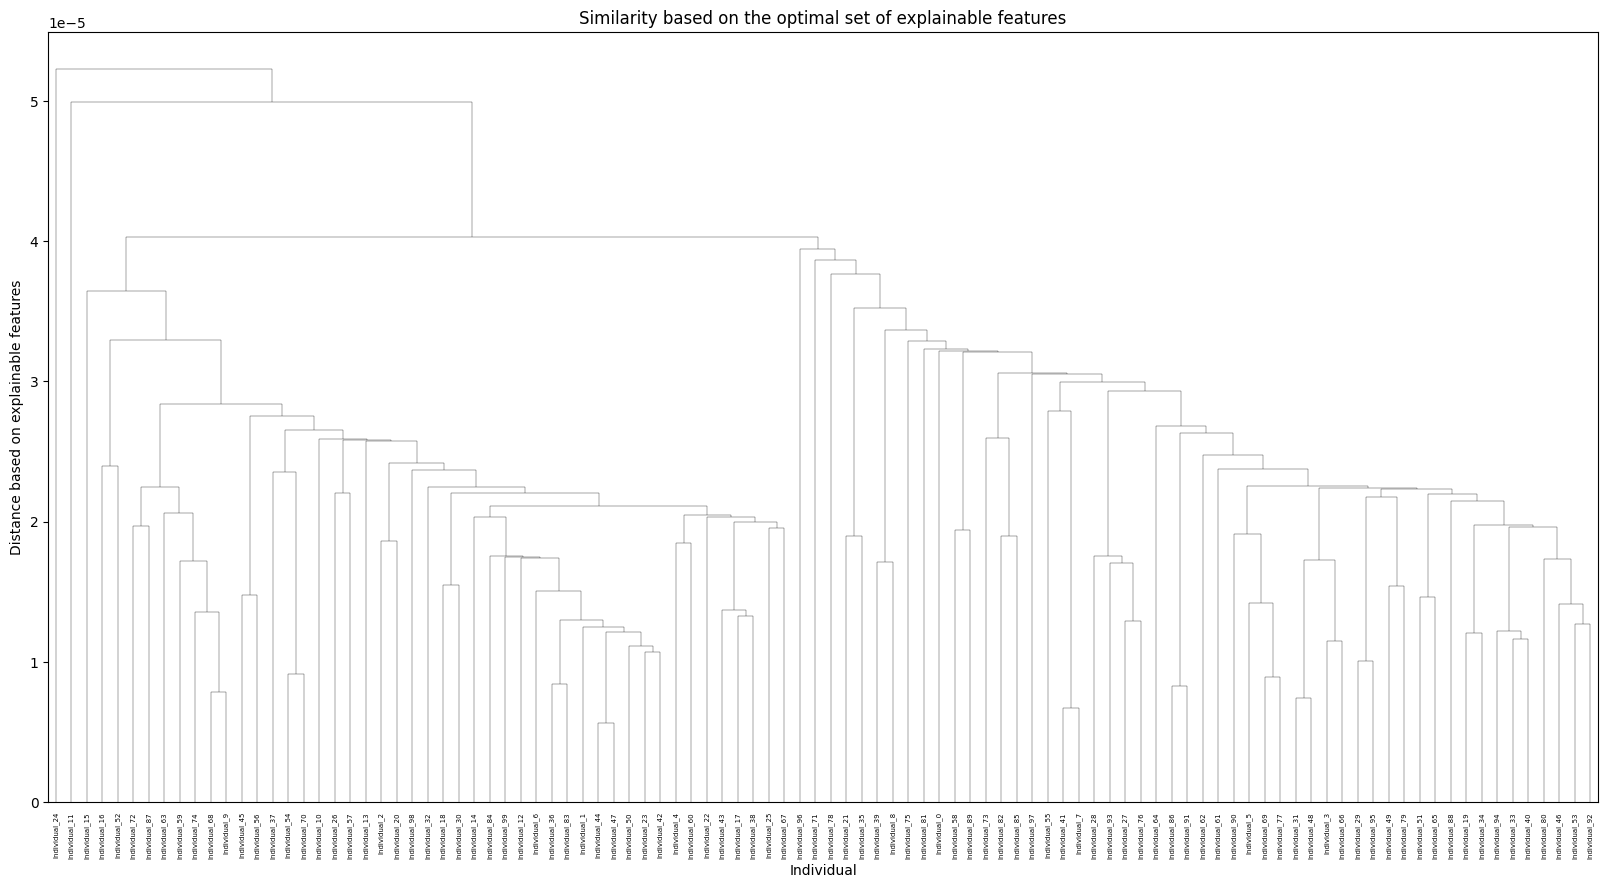

In [16]:
calculate_explainable_distances_result = ClusteringApplier.calculate_explainable_distances(
    use_config=False,
    df_explainable=preparation_result['explainable_df'].copy(),
    df_observable_distances=observable_patterns_result['pw_norm_dist'].copy(),
    explaining_features=explaining_features,
    method='exact',
    distance_measure='correlation',
    sparsity_parameter=0.01,
    max_num_threads=12,
    group_name=index_name
)

In [17]:
calculate_explainable_distances_result['overview_df']

,correlation,Age,Weight,Is_a_Zebra,Loves_to_sleep,Noise_1,Noise_2,Noise_3,Noise_4,Noise_5
0,0.38617,1,0,0,1,0,0,0,0,1


In [18]:
def ward_distance(x, y):
    # Compute the centroids of the two clusters
    centroid_x = torch.mean(x, dim=0)
    centroid_y = torch.mean(y, dim=0)

    # Compute the variance within each cluster
    var_x = torch.sum((x - centroid_x) ** 2) / (x.shape[0] - 1)
    var_y = torch.sum((y - centroid_y) ** 2) / (y.shape[0] - 1)

    # Compute the variance between the two clusters
    var_between = torch.sum((centroid_x - centroid_y) ** 2)

    # Compute the Ward distance
    return var_between + var_x + var_y

In [19]:
keystr = 'df_observable_data'

x = torch.tensor(observable_patterns_result[keystr].loc[:, observed_features].to_numpy())
y = torch.tensor(observable_patterns_result['df_cluster_median'].to_numpy())

alternative = ((x.unsqueeze(1) - y.unsqueeze(0)).pow(2).clamp(min=1e-20)).sum(2).sqrt()

vergleich = observable_patterns_result['df_observable_data'].pattern_type == alternative.argmin(dim=1).numpy() #torch.cdist(x, y).argmin(dim=1).numpy()
print(vergleich)
print(vergleich.sum() / observable_patterns_result[keystr].shape[0])

print(alternative.argmin(dim=1).numpy()[:23])
print(observable_patterns_result['df_observable_data'].pattern_type[:23].to_numpy())

0       False
1       False
2       False
3        True
4       False
        ...  
9995     True
9996     True
9997    False
9998    False
9999    False
Name: pattern_type, Length: 10000, dtype: bool
0.6924
[ 2 11  0  2  1  5  0  8  0  8  9  3  6  0  3  8  1  5  5 12  6 11  9]
[10  4  6  2  8  5  0  8  0  1  9  3 12  0  3  8  1  5  5 12  6 12  9]


In [20]:
my_df = observable_patterns_result[keystr].copy()
my_df = my_df[my_df["oversampled"] == False]

In [21]:
my_df.loc[:, [index_name] + observed_features]

,Individual,unexplainable_1,unexplainable_2,unexplainable_3,unexplainable_4,if_zebra_then_age,explained_by_loves_to_sleep,Age_plus_Weight
0,Individual_61,0.917452,0.352982,0.399570,0.406689,0.106256,0.488065,0.746607
1,Individual_48,0.422601,0.646902,0.617092,0.579776,0.297247,0.257997,0.553311
2,Individual_46,0.246925,0.610968,0.607900,0.253348,0.677493,0.456336,0.817746
3,Individual_6,0.785824,0.826234,0.487825,0.557869,0.500613,0.733922,0.718684
4,Individual_5,0.177659,0.386834,0.144609,0.504034,0.734109,0.224676,0.499456
...,...,...,...,...,...,...,...,...
9995,Individual_71,0.308740,0.092590,0.699719,0.509808,0.913583,0.204071,0.053825
9996,Individual_81,0.013409,0.022580,0.673934,0.501254,0.345142,0.006827,0.273965
9997,Individual_65,0.052310,0.745675,0.672998,0.179141,0.309577,0.933875,0.470488
9998,Individual_7,0.954413,0.403267,0.369469,0.520765,0.502515,0.664814,0.503095


In [22]:
df_observable_distances = observable_patterns_result['pw_norm_dist']
df_observable_distances.head()

Individual,Individual_0,Individual_1,Individual_10,Individual_11,Individual_12,Individual_13,Individual_14,Individual_15,Individual_16,Individual_17,...,Individual_90,Individual_91,Individual_92,Individual_93,Individual_94,Individual_95,Individual_96,Individual_97,Individual_98,Individual_99
Individual,,,,,,,,,,,,,,,,,,,,,
Individual_0,0.000000,0.000137,0.000091,0.000106,0.000120,0.000096,0.000121,0.000067,0.000089,0.000121,...,0.000107,0.000053,0.000105,0.000044,0.000036,0.000119,0.000061,0.000046,0.000136,0.000137
Individual_1,0.000137,0.000000,0.000139,0.000118,0.000139,0.000139,0.000139,0.000139,0.000139,0.000139,...,0.000139,0.000128,0.000139,0.000136,0.000130,0.000095,0.000132,0.000127,0.000038,0.000019
Individual_10,0.000091,0.000139,0.000000,0.000139,0.000133,0.000042,0.000134,0.000126,0.000135,0.000134,...,0.000107,0.000087,0.000110,0.000103,0.000099,0.000136,0.000113,0.000088,0.000139,0.000139
Individual_11,0.000106,0.000118,0.000139,0.000000,0.000139,0.000139,0.000139,0.000076,0.000054,0.000139,...,0.000139,0.000123,0.000139,0.000086,0.000090,0.000121,0.000064,0.000111,0.000117,0.000119
Individual_12,0.000120,0.000139,0.000133,0.000139,0.000000,0.000119,0.000007,0.000139,0.000139,0.000021,...,0.000051,0.000103,0.000046,0.000135,0.000115,0.000090,0.000135,0.000109,0.000124,0.000133


In [23]:
fingerprint_df = ClusteringApplier._calculate_fingerprints(
    df = my_df,
    group_name = index_name,
    use_config=False,
)

In [24]:
fingerprint_distanzen, normierte_fingerprint_distanzen = ClusteringApplier.calculate_pairwise_fingerprint_distances(
    df = fingerprint_df,
    distance = 'jensenshannon'
)

In [25]:
@torch.jit.script
def torch_relative_entropy(x:torch.Tensor, y:torch.Tensor) -> torch.Tensor:
    return (x * torch.log(x/y))

In [26]:
@torch.jit.script
def new_torch_matrix_jensenshannon(A:torch.Tensor) -> torch.Tensor:

    ########################################################################################
    ### Conversion of the jensenshannon distance from scipy.spatial.distance to pytorch. ###
    ########################################################################################

    """
    Compute the pairwise Jensen-Shannon distance (metric) between
    all entries in a matrix. This is the square root
    of the Jensen-Shannon divergence.

    The Jensen-Shannon distance between two probability
    vectors `p` and `q` is defined as,

    .. math::

       \\sqrt{\\frac{D(p \\parallel m) + D(q \\parallel m)}{2}}

    where :math:`m` is the pointwise mean of :math:`p` and :math:`q`
    and :math:`D` is the Kullback-Leibler divergence.

    This routine will normalize `p` and `q` if they don't sum to 1.0.

    Parameters
    ----------
    A : (N,M) array_like
        matrix of probability vectors
    
    Returns
    -------
    js : double or ndarray
        The Jensen-Shannon distances along the `axis`.

    """
    
    clamped_A = A.clamp(min = 1e-20)
    normalized_A = clamped_A / torch.sum(clamped_A, dim=1).unsqueeze(-1)
    m_A = (normalized_A.unsqueeze(-1) + normalized_A.T).permute(2,0,1) / 2.0
    relative_entropies = torch_relative_entropy(normalized_A, m_A) + 1e-10
    js = (relative_entropies.sum(dim = 2) + relative_entropies.sum(dim = 2).T).clamp(min = 0.)
    return (js / 2.0).sqrt()

In [229]:
class FeatureSelectionModel(Paremeterized_Model):
    def __init__(self, df_explainable:pd.DataFrame, df_observable:pd.DataFrame, df_cluster:pd.DataFrame|torch.Tensor, index_name:str, num_samples:int=1, power:int=4, penalty=0., device='cpu', clip_value=0, dtype=torch.float64):
        super().__init__(device, dtype)

        self.df_explainable = df_explainable.copy()
        self.df_explainable.sort_index(inplace=True)

        self.df_observable = df_observable.copy()
        self.df_observable.sort_values(index_name, inplace=True)
        self.df_observable.reset_index(inplace=True, drop=True)

        self.tensor_explainable = torch.tensor(self.df_explainable.to_numpy(), dtype=self.dtype, device=self.device).clamp(min=1e-20, max=1.)
        self.tensor_observable  = torch.tensor(self.df_observable.set_index(index_name).to_numpy(), dtype=self.dtype, device=self.device).clamp(min=1e-20, max=1.)

        if isinstance(df_cluster, pd.DataFrame):
            self.cluster_positions  = torch.tensor(df_cluster.to_numpy(), dtype=self.dtype, device=self.device).clamp(min=1e-20)
        else:
            self.cluster_positions = df_cluster.to(self.dtype).to(self.device)

        self.unique_groups = sorted(self.df_observable.loc[:, index_name].unique())
        self.number_of_groups = len(self.unique_groups)
        self.number_of_observations = self.df_observable.shape[0]
        self.mask_tensor = torch.zeros((self.number_of_observations, self.number_of_groups), device=self.device, dtype=self.dtype)

        for name, i in zip(self.unique_groups, np.arange(len(self.unique_groups))):
            _masking_list = (list(self.df_observable.query(f'{index_name} == "{name}"').index))
            self.mask_tensor[_masking_list, i] = 1.
            if name == 'Individual_0':
                self.masking_1 = _masking_list

        # Some sanity check
        for name, i in zip(self.unique_groups, np.arange(len(self.unique_groups))):
            lis = (self.mask_tensor.unsqueeze(2) * self.tensor_observable.unsqueeze(1))[:, i, :].nonzero()[:, 0].unique().numpy()
            a = self.df_observable.iloc[lis].loc[:, index_name]
            assert (a == name).all(), f'Failed sanity check for "{name}": {a}'

        self.power = power

        self.feature_names = list(self.df_explainable.columns)
        self.observation_names = list(df_observable.set_index(index_name).columns)

        self.penalty = torch.tensor(penalty, device=self.device, dtype=self.dtype)
        self.num_samples = num_samples
        
        self._add_sigmoid_param('feature_weights', N=len(self.feature_names), value=0.500, noise=0.100)
        self._add_sigmoid_param('observation_weights', N=len(self.observation_names), value=0.500, noise=0.250)

        self.add_param('cluster_positions', self.cluster_positions.logit(), lambda x: x.sigmoid())
        
        self.best_loss = None 
        self.best_feature_weights = None
        self.best_observation_weights = None

        if clip_value > 0:
            for p in self.parameters.parameters():
                print(p)
                p.register_hook(lambda grad: torch.clamp(grad, -clip_value, clip_value))
 

    def _add_param_from_mean_std(self, param_name='', N=1, mean=0.5, std=0.05, noise=0.1):
        alpha, beta = mean_std_to_beta_params(mean, std)
        
        noise_1 = torch.rand(N)
        noise_2 = torch.rand(N)

        feature_alpha_init = alpha * torch.ones(N) * (1.-noise) + noise_1 * noise
        feature_beta_init  = beta  * torch.ones(N) * (1.-noise) + noise_2 * noise

        self.add_param(f'{param_name}_alpha', torch.log(feature_alpha_init), lambda x: x.exp())
        self.add_param(f'{param_name}_beta',  torch.log(feature_beta_init),  lambda x: x.exp())

    def _add_sigmoid_param(self, param_name='', N=1, value=None, noise=0.1):

        noise_1 = torch.rand(N)
        noisy_value = value * torch.ones(N) * (1.-noise) + noise_1 * noise
        init_value = torch.logit(noisy_value)

        self.add_param(param_name, init_value, lambda x: x.sigmoid()) # [-1., 1.] --> [0, 2]
        #foo = lambda x: x/(1+x.abs())
        #self.add_param(param_name, init_value, lambda x: (foo(x) + 1.)/2.)

    def get_weights(self) -> dict:
        w = self.best_feature_weights
        feature_dict = {
            feature_name:float(weight) for feature_name, weight in zip(self.feature_names, w)
        }
        v = self.best_observation_weights
        observation_dict = {
            feature_name:float(weight) for feature_name, weight in zip(self.observation_names, v)
        }
        return feature_dict, observation_dict
        
    def save_if_best_loss(self, loss, feature_weights, observation_weights, cluster_positions):
        if self.best_loss is None:
            self.best_loss = loss.clone().detach()
            self.best_feature_weights = feature_weights.clone().detach()
            self.best_observation_weights = 1.00 + 1e-6 - observation_weights.clone().detach()
            self.best_cluster_positions = cluster_positions.clone().detach()
        elif loss < self.best_loss:
            self.best_loss = loss.clone().detach()
            self.best_feature_weights = feature_weights.clone().detach()
            self.best_observation_weights = 1.00 + 1e-6 - observation_weights.clone().detach()
            self.best_cluster_positions = cluster_positions.clone().detach()
    
    def plot(self):

        feature_weights = self.constrained('feature_weights').clone().detach().unsqueeze(0).numpy()
        observation_weights = self.constrained('observation_weights').clone().detach().unsqueeze(0).numpy()
        inv_observation_weights = 1.00 + 1e-6 - observation_weights 

        feature_weight_df = pd.DataFrame({self.feature_names[i]:feature_weights[:, i] for i in range(len(self.feature_names))})
        observation_weight_df = pd.DataFrame({self.observation_names[i]:inv_observation_weights[:, i] for i in range(len(self.observation_names))})

        plt.figure(figsize=(10, 5))
        ax1 = sns.barplot(feature_weight_df)
        ax1.axes.xaxis.set_tick_params(rotation=90)
        ax1.set_title('Feature Weights')
        plt.figure(figsize=(10, 5))
        ax2 = sns.barplot(observation_weight_df)
        ax2.axes.xaxis.set_tick_params(rotation=90)
        ax2.set_title('Observation Weights') 

    def sample_fingerprints(self, inv_observation_weights, cluster_positions):
        epsilon = 1e-20
        _dist = ((self.tensor_observable.unsqueeze(1) - cluster_positions.unsqueeze(0)).pow(2).clamp(min=epsilon) * inv_observation_weights).sum(2).sqrt()
        norm_dist = (_dist / _dist.sum(dim=1).unsqueeze(-1))
        masked_norm_dist = (self.mask_tensor.unsqueeze(2) * norm_dist.unsqueeze(1))
        accumulated_norm_dist = masked_norm_dist.sum(dim=0)
        fingerprint_distances = accumulated_norm_dist / accumulated_norm_dist.sum(dim=1).unsqueeze(-1)
        pow_fingerprints = ((fingerprint_distances.clamp(min=epsilon))**-1).pow(self.power) 
        sampled_fingerprints = Dirichlet(pow_fingerprints).rsample([self.num_samples]).mean(dim=0)
        return sampled_fingerprints

    def loss(self, data:torch.Tensor|None=None) -> torch.tensor:

        # feature_weights
        feature_weights = self.constrained('feature_weights')

        # observation_weights
        observation_weights = self.constrained('observation_weights')
        inv_observation_weights = 1.00 + 1e-6 - observation_weights 

        # cluster positions
        cluster_positions = self.constrained('cluster_positions').clamp(min = 1e-10, max=1e10)

        # fingerprints
        sampled_fingerprints = self.sample_fingerprints(inv_observation_weights, cluster_positions)

        # Construct the distance matrix for the fingerprints
        fingerprint_distances = new_torch_matrix_jensenshannon(sampled_fingerprints)

        # Construct the distance matrix for the features
        feature_distances = construct_distance_matrix(A=self.tensor_explainable, feature_weights=feature_weights)

        # Calculate the correlation between the distance matrix and the observable distances
        coef = pearson_corrcoef(feature_distances, fingerprint_distances)

        #k_penalty = (feature_weights.sum() * self.penalty)

        # Loss
        loss = -coef #+ k_penalty

        self.save_if_best_loss(loss, feature_weights, observation_weights, cluster_positions)

        return loss


In [861]:
model = next_model

In [1022]:
model.get_weights()

({'Age': 0.9857823903240139,
  'Weight': 6.390699987855406e-06,
  'Is_a_Zebra': 0.0007576475932205645,
  'Noise_1': 1.5977788241059233e-05,
  'Noise_2': 2.2294118943519341e-07,
  'Noise_3': 3.93084986339564e-09,
  'Noise_4': 4.52687484465697e-06,
  'Noise_5': 2.493867813429744e-09},
 {'unexplainable_1': 1.9648447372566658e-05,
  'unexplainable_2': 2.648119586656783e-05,
  'unexplainable_3': 4.236718527006467e-06,
  'unexplainable_4': 0.8252672335684343,
  'if_zebra_then_age': 0.9473910302290504,
  'Age_plus_Weight': 0.7655447470292521})

In [1117]:
model.best_observation_weights

tensor([1.9648e-05, 2.6481e-05, 4.2367e-06, 8.2527e-01, 9.4739e-01, 7.6554e-01],
       dtype=torch.float64)

In [1118]:
my_feature_weights = model.best_feature_weights

In [1119]:
my_feature_weights
my_feature_weights = torch.tensor([0.999, 1e-7, 0.999, 1e-7, 1e-7, 1e-7, 1e-7, 1e-7])

In [1120]:
model.best_observation_weights
my_observation_weights = torch.tensor([1e-7, 1e-7, 1e-7, 1e-7, 0.999, 1e-7])#model.best_observation_weights

In [1121]:
my_observation_weights = model.best_observation_weights

In [1122]:
sampled_fingerprints = model.sample_fingerprints(model.best_observation_weights, model.best_cluster_positions)
fingerprint_distances = new_torch_matrix_jensenshannon(sampled_fingerprints)
fingerprint_distances.shape

torch.Size([100, 100])

In [1123]:
fdm1 = construct_distance_matrix(A=model.tensor_explainable, feature_weights=my_feature_weights)

In [1124]:
fdm2 = construct_distance_matrix(A=model.tensor_explainable * my_feature_weights, feature_weights=torch.tensor(1.))

In [1125]:
pearson_corrcoef(fdm1, fingerprint_distances)

tensor(0.4031, dtype=torch.float64)

In [1126]:
pearson_corrcoef(fdm2, fingerprint_distances)

tensor(0.3804, dtype=torch.float64)

In [1127]:
model.df_explainable.iloc[86]

Age           0.499472
Weight        0.247384
Is_a_Zebra    0.998564
Noise_1       0.629392
Noise_2       0.437682
Noise_3       0.845553
Noise_4       0.969373
Noise_5       0.118447
Name: Individual_87, dtype: float64

In [1128]:
#mi = model.df_explainable.Loves_to_sleep.min()
#p = model.df_explainable.query(f'Loves_to_sleep == {mi}')
mi = model.df_explainable.Age.min()
p = model.df_explainable.query(f'Age == {mi}')
p

,Age,Weight,Is_a_Zebra,Noise_1,Noise_2,Noise_3,Noise_4,Noise_5
Individual,,,,,,,,
Individual_25,-0.001811,0.802471,0.999542,0.00027,0.530347,0.311026,0.31275,0.941873


In [1129]:
#ma = model.df_explainable.Loves_to_sleep.max()
#q = model.df_explainable.query(f'Loves_to_sleep == {ma}')
ma = model.df_explainable.Age.max()
q = model.df_explainable.query(f'Age == {ma}')
q

,Age,Weight,Is_a_Zebra,Noise_1,Noise_2,Noise_3,Noise_4,Noise_5
Individual,,,,,,,,
Individual_63,1.002025,0.097236,0.999748,0.934427,0.810331,0.688965,0.633527,0.261519


In [1130]:
lowest_value_index = model.df_explainable.reset_index().query(f'Individual == "{p.iloc[0].name}"').index[0]
highest_value_index = model.df_explainable.reset_index().query(f'Individual == "{q.iloc[0].name}"').index[0]

In [1131]:
rndm = np.random.randint(0, 99)

In [1132]:
# low->low, low->high
(fdm1[lowest_value_index][lowest_value_index].numpy() * 100000).round(0), (fdm1[lowest_value_index][highest_value_index].numpy() * 100000).round(0)

(np.float64(0.0), np.float64(6.0))

In [1133]:
# high->low, high->high
(fdm1[highest_value_index][lowest_value_index].numpy() * 100000).round(0), (fdm1[highest_value_index][highest_value_index].numpy() * 100000).round(0)

(np.float64(6.0), np.float64(0.0))

In [1134]:
# rndm->low, rndm->high
(fdm1[rndm][lowest_value_index].numpy() * 100000).round(0), (fdm1[rndm][highest_value_index].numpy() * 100000).round(0)

(np.float64(21.0), np.float64(6.0))

In [1135]:
(fdm2[rndm][lowest_value_index].numpy() * 100000).round(0), (fdm2[rndm][highest_value_index].numpy() * 100000).round(0)

(np.float64(22.0), np.float64(6.0))

In [1136]:
(fingerprint_distances[rndm][lowest_value_index].numpy() * 1000).round(0), (fingerprint_distances[rndm][highest_value_index].numpy() * 1000).round(0)

(np.float64(742.0), np.float64(37.0))

In [1145]:
rndm = np.random.randint(0, 99)
(fdm1[rndm].numpy() * 100000).round(0)

array([ 0., 21.,  6., 13., 11.,  6., 11., 11., 11., 11., 21.,  0.,  6.,
        6., 21., 11., 21.,  0., 21., 21., 21., 10., 21.,  0., 21.,  0.,
       11.,  0.,  0.,  0., 21., 21., 11., 21., 11.,  0., 21., 21., 11.,
       11., 11.,  0., 11.,  0.,  0.,  0., 21.,  0., 11.,  0., 21., 21.,
       11., 21.,  0.,  6., 11., 21.,  0.,  0.,  6.,  0.,  0.,  0., 21.,
        6.,  0., 18., 21., 21., 11., 21.,  6., 21., 21.,  0.,  0.,  0.,
        5.,  0., 21., 20., 21., 21., 10.,  0., 11.,  0.,  5.,  6.,  0.,
        0.,  0.,  0.,  0.,  2.,  0.,  0., 21., 21.])

In [1146]:
(fingerprint_distances[rndm].numpy() * 1000).round(0)

array([ 93., 730., 148., 611., 207., 116., 152., 205., 308., 192., 699.,
       111., 116., 137., 114., 209., 758.,  85., 695., 714., 355., 301.,
       451.,  70., 681., 101., 141.,  43.,  48.,  85., 754., 730., 112.,
       328., 171.,   0., 372., 739., 204., 207.,  91.,  98., 209.,  10.,
       253.,  96., 686.,  24., 313.,  47., 699., 196., 137., 636., 127.,
       131., 208., 742.,  72.,  19., 125., 255., 136.,  47., 756., 129.,
        42.,  50., 731., 595., 137., 608., 115., 332., 207.,  27., 136.,
       285., 298.,  77., 432., 595., 762., 757., 592.,  87.,  87.,  27.,
       352., 140.,  51., 109.,  92.,  54.,  33., 621., 216.,   8., 664.,
       715.])

In [1147]:
np.corrcoef(fdm1[rndm], fingerprint_distances[rndm].numpy())

array([[1.        , 0.77614862],
       [0.77614862, 1.        ]])

In [1140]:
np.corrcoef(fdm1.flatten(), fingerprint_distances.numpy().flatten())

array([[1.        , 0.40309883],
       [0.40309883, 1.        ]])

In [1141]:
np.corrcoef(fdm2[rndm], fingerprint_distances[rndm].numpy())

array([[ 1.        , -0.50606463],
       [-0.50606463,  1.        ]])

In [659]:
Tier_0 = np.array([0.5, 0.0]) # Alter: Mittel, KEIN Zebra
Tier_1 = np.array([0.0, 1.0]) # Alter: Jung,   Zebra
Tier_2 = np.array([1.0, 1.0]) # Alter: Alt,    Zebra

[
    correlation(Tier_0, Tier_1, centered=False),
    correlation(Tier_0, Tier_2, centered=False),
    correlation(Tier_1, Tier_2, centered=False),
]

[np.float64(1.0),
 np.float64(0.29289321881345254),
 np.float64(0.29289321881345254)]

In [660]:
torch_matrix_correlation(
    torch.tensor([
        Tier_0,
        Tier_1,
        Tier_2
    ]),
    w = torch.tensor([1., 1e-10])
)

tensor([[0.0000e+00, 1.0000e+00, 5.0000e-11],
        [1.0000e+00, 0.0000e+00, 9.9999e-01],
        [5.0000e-11, 9.9999e-01, 0.0000e+00]], dtype=torch.float64)

In [132]:
torch_matrix_correlation(
    torch.tensor([
        Tier_0,
        Tier_1,
        Tier_2
    ]),
    w = torch.tensor([1., 1])
)

tensor([[0.0000, 1.0000, 0.2929],
        [1.0000, 0.0000, 0.2929],
        [0.2929, 0.2929, 0.0000]], dtype=torch.float64)

In [129]:
torch.tensor([
        Tier_0,
        Tier_1,
        Tier_2
    ])

tensor([[0.5000, 0.0000],
        [0.0000, 1.0000],
        [1.0000, 1.0000]], dtype=torch.float64)

In [128]:
w = torch.tensor([1., 1e-10])
w = w / w.sum()
torch.tensor([
    Tier_0,
    Tier_1,
    Tier_2
]) * w

tensor([[5.0000e-01, 0.0000e+00],
        [0.0000e+00, 1.0000e-10],
        [1.0000e+00, 1.0000e-10]], dtype=torch.float64)

In [148]:
Tier_0, Tier_2

(array([0.5, 0. ]), array([1., 1.]))

In [149]:
correlation([0.5, 0., 0.], [1., 1., 0.], centered=False, w=[1., 1., 1.])

np.float64(0.29289321881345254)

In [153]:
correlation([0.5, 0., 0.], [1., 1., 0.], centered=False, w=[1., 1e-10, 1.])

np.float64(5.000000413701855e-11)

In [137]:
correlation(Tier_0, Tier_2, centered=False, w=[1., 1.])

np.float64(0.29289321881345254)

In [138]:
correlation(Tier_0, Tier_2, centered=False, w=[1., 1e-10])

np.float64(5.000000413701855e-11)

In [157]:
correlation(
    np.array([0.028, 0.999]),
    np.array([1.000, 1.000]),
    centered=False,
    w=[1,0.00001]
)

np.float64(0.005955107656836156)

In [88]:
correlation(df_explainable.loc['Individual_1', ['Age', 'Is_a_Zebra']].to_numpy().clip(min=0), df_explainable.loc['Individual_2', ['Age', 'Is_a_Zebra']].to_numpy().clip(min=0), centered=False)

np.float64(0.292740206450986)

In [ ]:
correlation(df_explainable.loc['Individual_0', ['Age', 'Is_a_Zebra']].to_numpy().clip(min=0), df_explainable.loc['Individual_1', ['Age', 'Is_a_Zebra']].to_numpy().clip(min=0), centered=False)

np.float64(0.9975204890409671)

In [ ]:
correlation([0.5, 0.], [0., 1.], centered=False) # 

np.float64(1.0)

In [29]:
from gradient_solver import _construct_distance_matrix

In [230]:
df_explainable = preparation_result['explainable_df'].copy().set_index(index_name)
df_observable = observable_patterns_result['df_observable_data'].copy().set_index(index_name).loc[:, observed_features].reset_index()

In [231]:
model = FeatureSelectionModel(
    df_explainable,
    df_observable,
    observable_patterns_result['df_cluster_median'],
    power = 2,
    index_name = 'Individual',
    num_samples = 4,
    dtype = torch.float64,
    device = 'cpu',
    penalty=0
)

# After this many steps, the learning rate is halved
HALFLIFE = 30

optimizer = torch.optim.RMSprop(
    params = [
        {'params': model.parameters['feature_weights'], 'lr': 0.1, 'momentum': 0.50},
        {'params': model.parameters['observation_weights'], 'lr': 0.1, 'momentum': 0.50},
        {'params': model.parameters['cluster_positions'], 'lr': 0.1, 'momentum': 0.50},
    ],

)

lr_halflife = lambda epochs: 0.5**(1/epochs)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda = lambda epoch: lr_halflife(HALFLIFE)**epoch)
trainer = Trainer(model = model, optimizer = optimizer, scheduler = scheduler, dataloader = range(100))
print(f'Loss before training: {model.loss().clone().detach()}')
trainer.train(epochs = 10, timeout=60000)

Loss before training: -0.2882660996163003
1/10 --- Mean Loss : -0.9399452321228052
2/10 --- Mean Loss : -0.9944516067713091
3/10 --- Mean Loss : -0.9967246535636793
4/10 --- Mean Loss : -0.9983088048948182
5/10 --- Mean Loss : -0.9987452132778438
6/10 --- Mean Loss : -0.9990630500112667
7/10 --- Mean Loss : -0.9990343970971878
8/10 --- Mean Loss : -0.9991862372501439
9/10 --- Mean Loss : -0.9991892638396687
10/10 --- Mean Loss : -0.9991207177127518


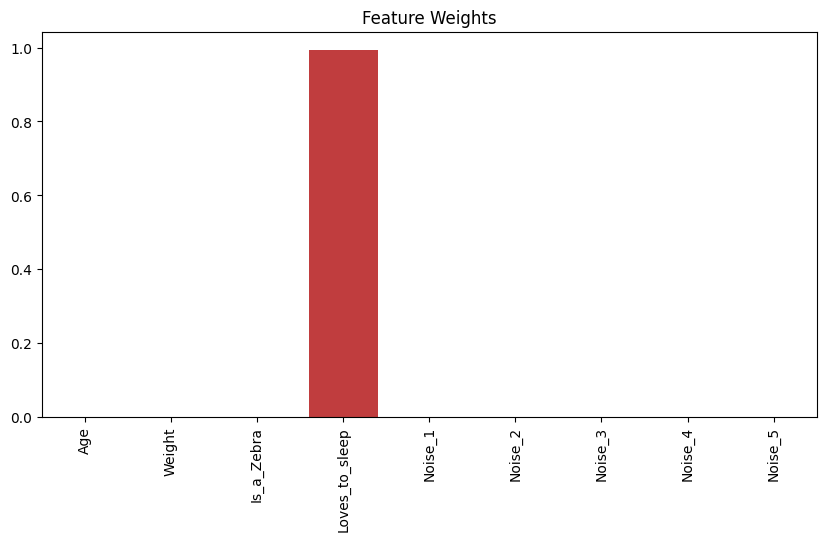

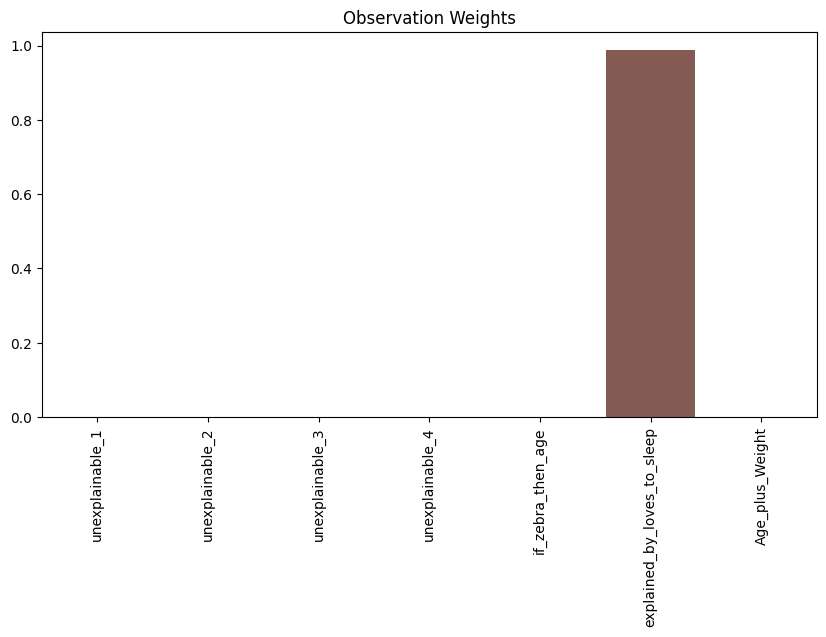

In [232]:
model.plot()

In [857]:
feature_dict, observation_dict = model.get_weights()

remaining_features = []
for k,v in feature_dict.items():
    if v < 0.500:
        remaining_features.append(k)

i = 0
remaining_observations = [index_name]
remaining_observation_indices = []
for k,v in observation_dict.items():
    if v < 0.500:
        remaining_observations.append(k)
        remaining_observation_indices.append(i)
    i += 1

In [858]:
remaining_features, remaining_observations

(['Age',
  'Weight',
  'Is_a_Zebra',
  'Noise_1',
  'Noise_2',
  'Noise_3',
  'Noise_4',
  'Noise_5'],
 ['Individual',
  'unexplainable_1',
  'unexplainable_2',
  'unexplainable_3',
  'unexplainable_4',
  'if_zebra_then_age',
  'Age_plus_Weight'])

In [859]:
next_model = FeatureSelectionModel(
    df_explainable.loc[:, remaining_features],
    df_observable.loc[:, remaining_observations],
    model.best_cluster_positions[:, remaining_observation_indices],
    power = 4,
    index_name = 'Individual',
    num_samples = 4,
    dtype = torch.float64,
    device = 'cpu',
    penalty=0
)

# After this many steps, the learning rate is halved
HALFLIFE = 50

optimizer = torch.optim.RMSprop(
    params = [
        {'params': next_model.parameters['feature_weights'], 'lr': 0.1, 'momentum': 0.50},
        {'params': next_model.parameters['observation_weights'], 'lr': 0.1, 'momentum': 0.50},
        {'params': next_model.parameters['cluster_positions'], 'lr': 0.1, 'momentum': 0.50},
    ],

)

lr_halflife = lambda epochs: 0.5**(1/epochs)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda = lambda epoch: lr_halflife(HALFLIFE)**epoch)
trainer = Trainer(model = next_model, optimizer = optimizer, scheduler = scheduler, dataloader = range(100))
print(f'Loss before training: {next_model.loss().clone().detach()}')
trainer.train(epochs = 10, timeout=60000)

Loss before training: -0.240308182317024
1/10 --- Mean Loss : -0.7420508905095753
2/10 --- Mean Loss : -0.7903942290935358
3/10 --- Mean Loss : -0.7925551038607318
4/10 --- Mean Loss : -0.7929532734949112
5/10 --- Mean Loss : -0.7930504566691504
6/10 --- Mean Loss : -0.793094201208864
7/10 --- Mean Loss : -0.7931611664638183
8/10 --- Mean Loss : -0.7932009765348104
9/10 --- Mean Loss : -0.7932545389705161
10/10 --- Mean Loss : -0.793303330982655


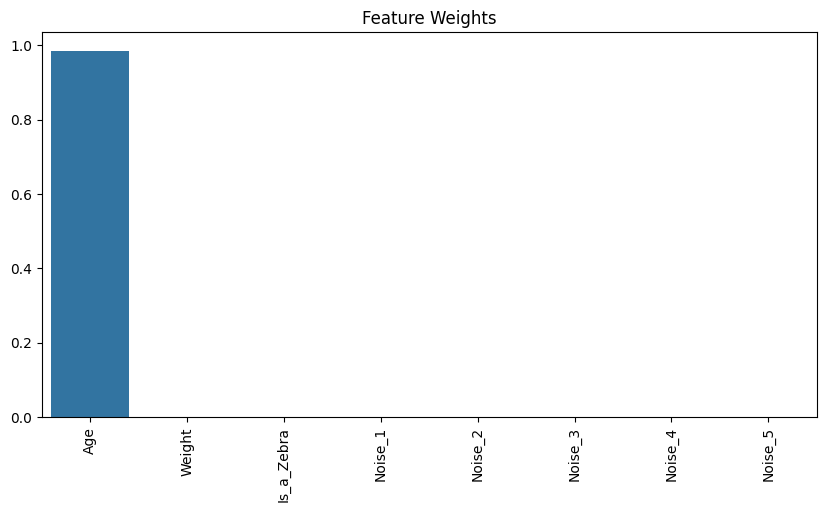

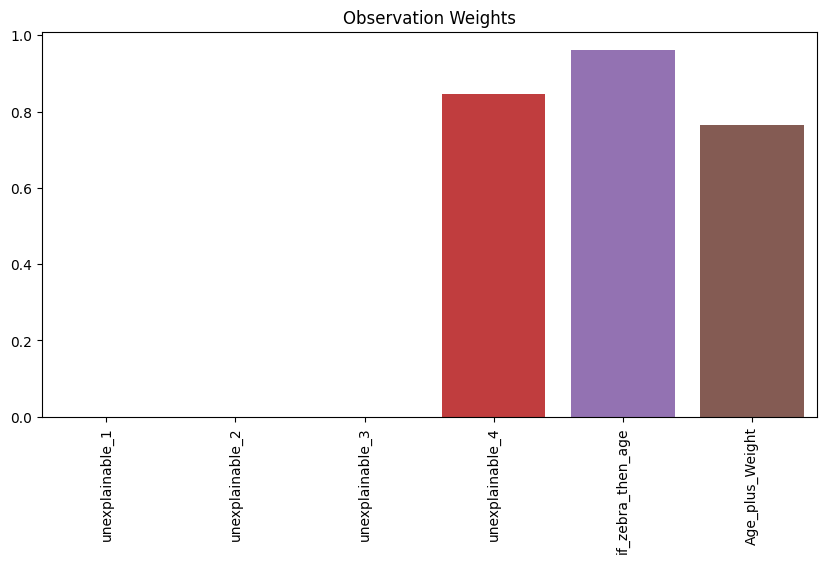

In [860]:
next_model.plot()

In [260]:
feature_dict, observation_dict = next_model.get_weights()

remaining_features = []
for k,v in feature_dict.items():
    if v < 0.500:
        remaining_features.append(k)

i = 0
remaining_observations = [index_name]
remaining_observation_indices = []
for k,v in observation_dict.items():
    if v < 0.500:
        remaining_observations.append(k)
        remaining_observation_indices.append(i)
    i += 1

remaining_features, remaining_observations

(['Weight',
  'Is_a_Zebra',
  'Noise_1',
  'Noise_2',
  'Noise_3',
  'Noise_4',
  'Noise_5'],
 ['Individual', 'unexplainable_1', 'unexplainable_2', 'unexplainable_4'])

In [261]:
next2_model = FeatureSelectionModel(
    df_explainable.loc[:, remaining_features],
    df_observable.loc[:, remaining_observations],
    model.best_cluster_positions[:, remaining_observation_indices],
    power = 4,
    index_name = 'Individual',
    num_samples = 4,
    dtype = torch.float64,
    device = 'cpu',
    penalty=0
)

my_model = next2_model

# After this many steps, the learning rate is halved
HALFLIFE = 30

optimizer = torch.optim.RMSprop(
    params = [
        {'params': my_model.parameters['feature_weights'], 'lr': 0.1, 'momentum': 0.50},
        {'params': my_model.parameters['observation_weights'], 'lr': 0.1, 'momentum': 0.50},
        {'params': my_model.parameters['cluster_positions'], 'lr': 0.1, 'momentum': 0.50},
    ],

)

lr_halflife = lambda epochs: 0.5**(1/epochs)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda = lambda epoch: lr_halflife(HALFLIFE)**epoch)
trainer = Trainer(model = my_model, optimizer = optimizer, scheduler = scheduler, dataloader = range(100))
print(f'Loss before training: {my_model.loss().clone().detach()}')
trainer.train(epochs = 10, timeout=60000)

Loss before training: -0.025809228164522878
1/10 --- Mean Loss : -0.20352576580524273
2/10 --- Mean Loss : -0.31230133340198407
3/10 --- Mean Loss : -0.3244765300435824
4/10 --- Mean Loss : -0.32689836565853597
5/10 --- Mean Loss : -0.3272700116588542
6/10 --- Mean Loss : -0.3274396110127537
7/10 --- Mean Loss : -0.3277750399339126
8/10 --- Mean Loss : -0.32780205731989953
9/10 --- Mean Loss : -0.3281729753534406
10/10 --- Mean Loss : -0.3381821407964593


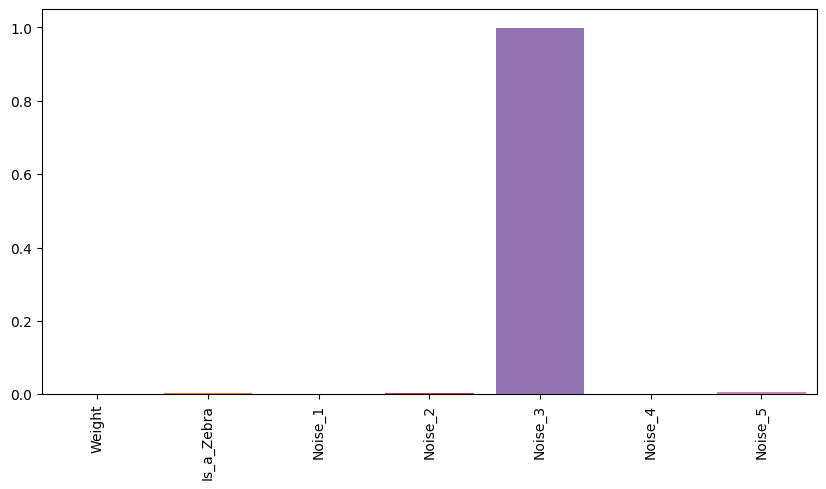

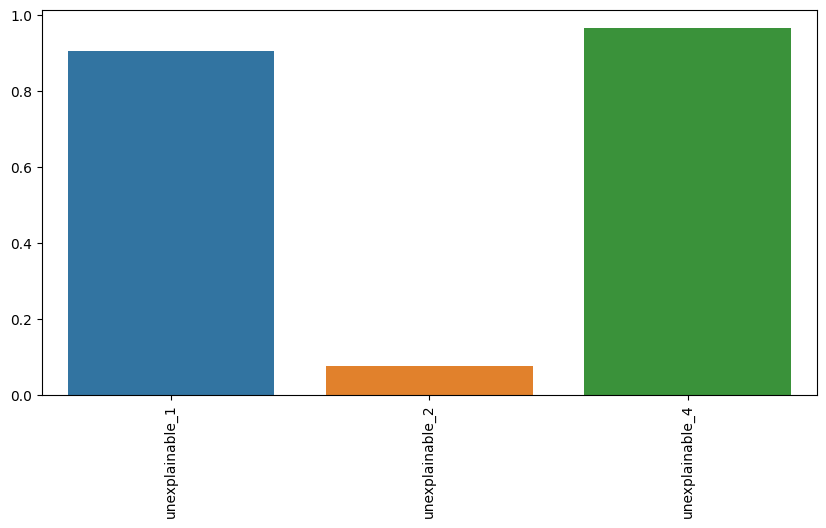

In [262]:
next2_model.plot()

In [264]:
feature_dict, observation_dict = next2_model.get_weights()

remaining_features = []
for k,v in feature_dict.items():
    if v < 0.500:
        remaining_features.append(k)

i = 0
remaining_observations = [index_name]
remaining_observation_indices = []
for k,v in observation_dict.items():
    if v < 0.500:
        remaining_observations.append(k)
        remaining_observation_indices.append(i)
    i += 1

remaining_features, remaining_observations

(['Weight', 'Is_a_Zebra', 'Noise_1', 'Noise_2', 'Noise_4', 'Noise_5'],
 ['Individual', 'unexplainable_2'])

In [265]:
next3_model = FeatureSelectionModel(
    df_explainable.loc[:, remaining_features],
    df_observable.loc[:, remaining_observations],
    model.best_cluster_positions[:, remaining_observation_indices],
    power = 4,
    index_name = 'Individual',
    num_samples = 4,
    dtype = torch.float64,
    device = 'cpu',
    penalty=0
)

my_model = next3_model

# After this many steps, the learning rate is halved
HALFLIFE = 30

optimizer = torch.optim.RMSprop(
    params = [
        {'params': my_model.parameters['feature_weights'], 'lr': 0.1, 'momentum': 0.50},
        {'params': my_model.parameters['observation_weights'], 'lr': 0.1, 'momentum': 0.50},
        {'params': my_model.parameters['cluster_positions'], 'lr': 0.1, 'momentum': 0.50},
    ],

)

lr_halflife = lambda epochs: 0.5**(1/epochs)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda = lambda epoch: lr_halflife(HALFLIFE)**epoch)
trainer = Trainer(model = my_model, optimizer = optimizer, scheduler = scheduler, dataloader = range(100))
print(f'Loss before training: {my_model.loss().clone().detach()}')
trainer.train(epochs = 10, timeout=60000)

Loss before training: -0.0017970740976259144
1/10 --- Mean Loss : -0.07043708047671106
2/10 --- Mean Loss : -0.0793538766788347
3/10 --- Mean Loss : -0.08018910991761304
4/10 --- Mean Loss : -0.0803970303678301
5/10 --- Mean Loss : -0.08079856936851301
6/10 --- Mean Loss : -0.08135705752311058
7/10 --- Mean Loss : -0.08143264940231669
8/10 --- Mean Loss : -0.08155948697982407
9/10 --- Mean Loss : -0.08142149477249236
10/10 --- Mean Loss : -0.08156384877897484


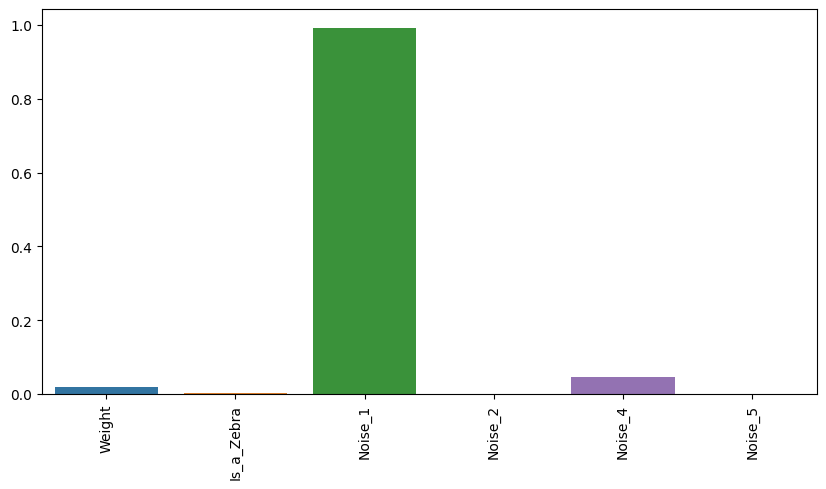

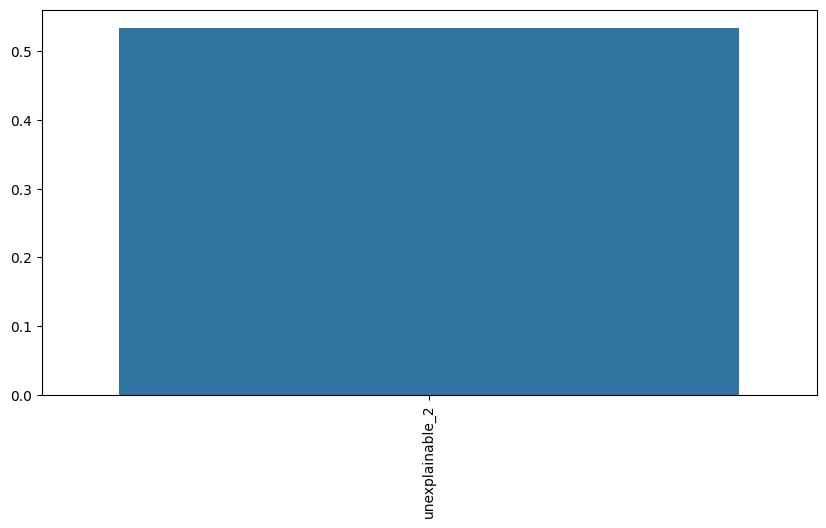

In [266]:
next3_model.plot()

In [263]:
...

Ellipsis